In [26]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet model
resnet50 = models.resnet50(pretrained=True)

# Freeze pre-trained layers
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the last fully connected layer for transfer learning
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)  # 3 output classes (positive, negative, neutral)
)
model = resnet50.to(device)
model_path = "/content/drive/MyDrive/APS360 Group/Data preprocessing/Roza CNN Model Graphs/saved_model_80_accuracy.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/APS360 Group/Data preprocessing/Test data', transform=transforms)

test_transforms= transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((244, 244)),
    transforms.Normalize(mean=[0.4509, 0.4269, 0.3913], std=[0.2789, 0.2737, 0.2865])
])

# Create an ImageFolder instance aka a dataloader
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/APS360 Group/Data preprocessing/Test data', transform=test_transforms)

In [19]:
batch_size = 32

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
print("len test_loader:", len(test_loader))

sentiments = ('Negative', 'Neutral', 'Positive')

len test_loader: 8


Accuracy: 0.475
Precision: 0.45697342912532785
Recall: 0.47500000000000003
F1 Score: 0.4545458383253503


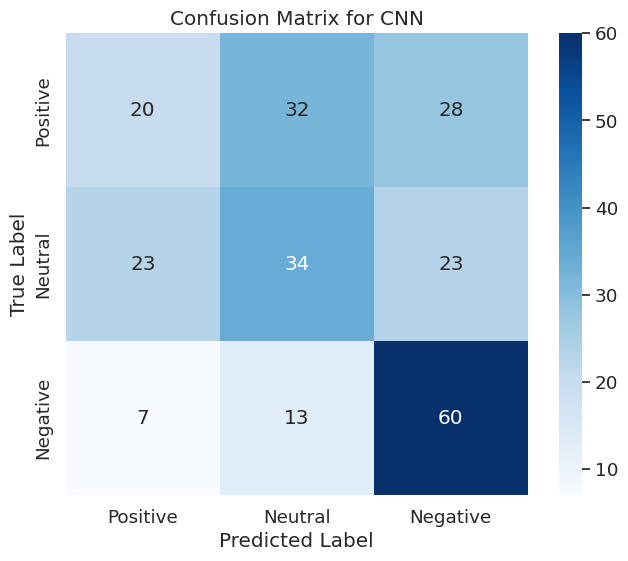

In [29]:
# 3. Run Inference
predictions = []
true_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      predictions.extend(predicted.tolist())
      true_labels.extend(labels.tolist())

# 4. Evaluate Performance
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')  # Use 'micro' or 'weighted' for multi-class problems
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 5. Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Convert confusion matrix to numpy array
conf_matrix_np = np.array(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(conf_matrix_np, annot=True, fmt="d", cmap="Blues", cbar=True, square=True,
                      xticklabels=["Positive", "Neutral", "Negative"],
                      yticklabels=["Positive", "Neutral", "Negative"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for CNN")

# Add colorbar
cbar = heatmap.collections[0].colorbar
cbar.set_label('', rotation=270, labelpad=20)

plt.show()